Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using mpiexec in global path
Warning! Using python in global path
*************************************************************

Loading Abaqus-mesh from D:\NDCIS\framework\data\abaqus_files\simple_sector\abaqus.inp
Can not read the given string list
WARNING 3D case were selected
Mesh D:\NDCIS\framework\data\abaqus_files\simple_sector\abaqus.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


<IPython.core.display.Javascript object>


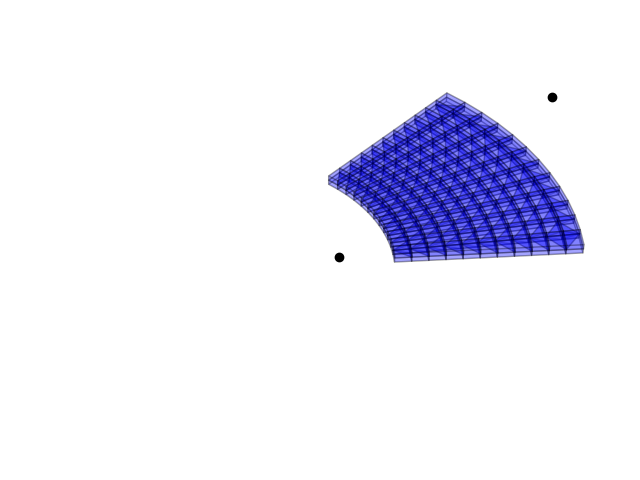

Element in mesh is not supported.
Element in mesh is not supported.
Element in mesh is not supported.
Element in mesh is not supported.


(-0.70710675999999995,
 14.849241959999999,
 -0.70710675999999995,
 14.849241959999999)

In [1]:
# importing lib and setting a list of meshes to be tested

import sys 
import amfe
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook


# making the path relative to the project
local_folder = os.getcwd()[:]
os.chdir('..')
project_folder = os.getcwd()[:]
os.chdir(local_folder)
sys.path.append(r'project_folder')

mesh_inp = os.path.join(project_folder,r'data\abaqus_files\simple_sector\abaqus.inp')


m = amfe.Mesh()
m.import_inp(mesh_inp,1.0)

m.split_in_groups()

g = m.groups.keys()

sub_domain = m.groups['SOLID_1_1_SOLID_ELSET']

sub_domain.create_elem_dict()


vertice_matrix = sub_domain.get_element(0)
points_coord = sub_domain.parent_mesh.nodes


ax = amfe.plot3Dmesh(m, ax=None, boundaries=True, alpha=0.2, color='blue', scale = 1000, plot_nodes=False)
ax.view_init(-90, 0)
#ax.set_aspect('equal', adjustable='box')
xlim = ax.get_xlim()
ax.set_ylim(xlim)
ax.set_zlim(xlim)
plt.axis('off')